In [1]:
library(Seurat)
# library(ArchR)
library(dplyr)
library(tidyr)
library(stringr)
library(ggrastr)
library(Seurat)
library(circlize)
library(ComplexHeatmap)
library(qs)

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggrastr’ was built under R version 4.2.3”
circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required pack

ERROR: Error in library(qs): there is no package called ‘qs’


# Correlation of ATAC

In [ ]:
load("/data/work/Brain/project/ATAC/human_macaca_mouse_combined_homer_del.RData")

In [4]:
all.meta = proj@meta.data
all.meta$species_celltype <- paste0(all.meta$celltype,"_",all.meta$species)

In [5]:
head(all.meta)

,orig.ident,nCount_RNA,nFeature_RNA,Sample,species,percent.mt,RNA_snn_res.0.8,seurat_clusters,celltype,species_celltype
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>,<chr>
CELL1_N1_10,SeuratProject,2726.203,1809,T764T765,Human,2.2076035,2,2,EX_L23_IT,EX_L23_IT_Human
CELL4_N1_10,SeuratProject,3726.969,2328,T764T765,Human,2.7866977,3,3,EX_L23_IT,EX_L23_IT_Human
CELL14_N1_10,SeuratProject,4959.242,2784,T764T765,Human,2.2637146,4,4,EX_L6_CT,EX_L6_CT_Human
CELL19_N1_10,SeuratProject,1863.266,1377,T764T765,Human,0.9012302,0,0,EX_L4_IT,EX_L4_IT_Human
CELL21_N1_10,SeuratProject,4278.473,2631,T764T765,Human,2.2186613,3,3,EX_L23_IT,EX_L23_IT_Human
CELL23_N1_10,SeuratProject,5878.981,3291,T764T765,Human,3.6693920,1,1,EX_L5_IT,EX_L5_IT_Human


In [6]:
reorder_matrix <- function(matrix1, by.rows = TRUE) {
  if (by.rows == TRUE) {
    conf.order <- order(apply(matrix1, 1, which.max))
    matrix1.reordered <- matrix1[conf.order, ]
  } else {
    conf.order <- order(apply(matrix1, 2, which.max))
    matrix1.reordered <- matrix1[, conf.order]
  }
}

compare_cl <- function(cl, ref.cl,
                       plot.title = NA, plot.silent = TRUE,
                       heat.colors = colorRampPalette(c("white", "grey70", "black"))(100),
                       row.cl.num = min(length(unique(cl)),
                                        length(unique(ref.cl)))) {
  library(grid)
  library(pheatmap)
  
  conf1 <- table(cl, ref.cl)
  conf1 <- sweep(conf1, 1, rowSums(conf1), "/")
  conf2 <- reorder_matrix(conf1)
  
  # Cluster co-occurence
  cl.prop.cocl <- apply(conf1, 2, function(x) {
    grid1 <- expand.grid(x, x)
    min.prop <- apply(grid1, 1, min)
  })
  
  cl.prop.cocl.total <- apply(cl.prop.cocl, 1, sum)
  cl.prop.cocl.m <- matrix(cl.prop.cocl.total, nrow(conf1), nrow(conf1),
                           dimnames = list(rownames(conf1), rownames(conf1)))
  
  ph1 <- pheatmap(conf2, cutree_rows = row.cl.num, clustering_method = "ward.D2",
                  # annotation_row = ref.cl.anno[, -grep("cluster_label", colnames(ref.cl.anno))],
                  color = heat.colors, fontsize = 6,
                  main = plot.title, silent = plot.silent)
  return(list(conf = conf2, cocl = cl.prop.cocl.m, ph = ph1))
}
# Heatmap palette
#heat.colors <- colorRampPalette(c("grey99", "orange", "red"))(100)
heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)

In [7]:
# ref.cl <- all.meta$all_index.species
ref.cl <- all.meta$species_celltype
cca.cl <- all.meta$RNA_snn_res.0.8

In [8]:
cl.conf <- compare_cl(ref.cl, cca.cl)
cocl <- cl.conf$cocl


Attaching package: ‘pheatmap’


The following object is masked from ‘package:ComplexHeatmap’:

    pheatmap




In [9]:
compare.species<-c("Macaque","Mouse","Human")

In [61]:
cocl.subset3 <- cocl[grepl(compare.species[2], row.names(cocl)),
                    grepl(compare.species[1], row.names(cocl))]

In [64]:
# # order row by hclust
tmpDist = as.dist(1-cor(cocl.subset3))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order
all_3=rownames(cocl.subset3)
cocl.subset3 = cocl.subset3[all_3, ]
cocl.subset3 = reorder_matrix(cocl.subset3, by.rows=F)
# all_n=rownames(cocl.subset.test)

In [65]:
head(cocl.subset3)

,ASC_Macaca,Endo_Macaca,EX_L23_IT_Macaca,EX_L4_IT_Macaca,EX_L6_IT_Car3_Macaca,EX_L6_CT_Macaca,EX_L5_NP_Macaca,EX_L5_IT_Macaca,EX_L6_IT_Macaca,IN_LAMP5_Macaca,IN_PVALB_Macaca,IN_SST_Macaca,IN_VIP_Macaca,MCG_Macaca,OLIG_Macaca,OPC_Macaca
ASC_Mouse,0.189918229,0.004881757,0.000138831,0.000000000,0.002597403,0.003816794,0.003523194,0.0003334445,0.000000000,0.004403648,0.003523194,0.003816794,0.004682033,0.0030538519,0.004018980,0.005145283
Endo_Mouse,0.002068894,0.887790186,0.001149953,0.001011122,0.003608525,0.025312459,0.024266936,0.0013445668,0.001011122,0.029941148,0.011678451,0.015961638,0.034378160,0.0065822629,0.031821028,0.031838986
EX_L23_IT_Mouse,0.001965449,0.011747848,0.796163313,0.104187137,0.108345918,0.273130338,0.105578032,0.1135580446,0.212838015,0.026692130,0.016301295,0.024681678,0.013860353,0.0032032203,0.007467424,0.007462646
EX_L4_IT_Mouse,0.001965449,0.010127695,0.357457031,0.607079468,0.409423576,0.354673801,0.228054885,0.6596524103,0.476658359,0.018034119,0.007243989,0.014215857,0.007517770,0.0029603724,0.005889999,0.005638125
EX_L5_ET_Mouse,0.001034543,0.007187011,0.354693019,0.093018902,0.095511379,0.414455449,0.068474439,0.1023898096,0.202112748,0.035347326,0.022655657,0.031101520,0.022515550,0.0009310987,0.002418456,0.002413678
EX_L5_IT_Mouse,0.001965449,0.026540910,0.302352912,0.091794637,0.095953417,0.270844619,0.095130864,0.1011655438,0.200888482,0.064918373,0.272422729,0.278497979,0.056320631,0.0027602524,0.021638491,0.021633713


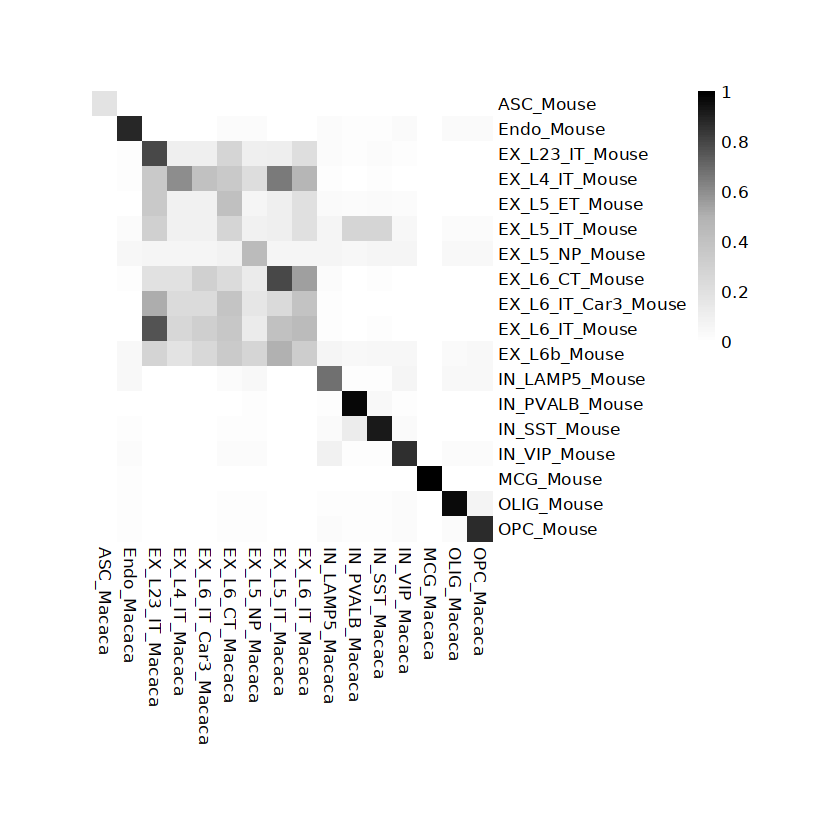

In [66]:
options(repr.plot.width=7, repr.plot.height=7)
pheatmap(cocl.subset3, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 


# Correlation of RNA

In [ ]:
integrated <- readRDS("/data/work/Brain/project/RNA/integrated.rds")

meta=integrated@meta.data
meta$celltype_species <- paste0(meta$celltype,":",meta$species)
integrated@meta.data = meta

In [ ]:
df=as.data.frame(integrated[['RNA']]@features)
gene=rownames(df[which(df$scale.data==TRUE),])

In [ ]:
DefaultAssay(object = integrated) <- "RNA"
Idents(integrated) <- "celltype_species"
levels(integrated) <- c('EX_L23_IT:Human','EX_L23_IT:Macaque','EX_L23_IT:Mouse','EX_L4_IT:Human','EX_L4_IT:Macaque','EX_L4_IT:Mouse',
                       'EX_L5_IT:Human','EX_L5_IT:Macaque','EX_L5_IT:Mouse','EX_L6_IT:Human','EX_L6_IT:Macaque','EX_L6_IT:Mouse',
                       'EX_L5_NP:Human','EX_L5_NP:Macaque','EX_L5_NP:Mouse','EX_L5_ET:Human','EX_L5_ET:Macaque','EX_L5_ET:Mouse',
                       'EX_L6_IT_Car3:Human','EX_L6_IT_Car3:Macaque','EX_L6_IT_Car3:Mouse','EX_L6_CT:Human','EX_L6_CT:Macaque','EX_L6_CT:Mouse',
                       'EX_L6b:Human','EX_L6b:Macaque','EX_L6b:Mouse','IN_LAMP5:Human','IN_LAMP5:Macaque','IN_LAMP5:Mouse','IN_VIP:Human','IN_VIP:Macaque','IN_VIP:Mouse',
                       'IN_SST:Human','IN_SST:Macaque','IN_SST:Mouse','IN_PVALB:Human','IN_PVALB:Macaque','IN_PVALB:Mouse','ASC:Human','ASC:Macaque','ASC:Mouse',
                       'OLIG:Human','OLIG:Macaque','OLIG:Mouse','OPC:Human','OPC:Macaque','OPC:Mouse','MCG:Human','MCG:Macaque','MCG:Mouse','Endo:Human','Endo:Macaque','Endo:Mouse')

In [ ]:
av1 <-AverageExpression(integrated,group.by = "celltype_species",assays = "RNA")
av1=av1[[1]]
test=av1[gene,levels]
test=as.matrix(test)

In [ ]:
levels=c('Human_EX-L23-IT','Macaque_EX-L23-IT','Mouse_EX-L23-IT','Human_EX-L4-IT','Macaque_EX-L4-IT','Mouse_EX-L4-IT','Human_EX-L5-IT','Macaque_EX-L5-IT','Mouse_EX-L5-IT',
       'Human_EX-L6-IT','Macaque_EX-L6-IT','Mouse_EX-L6-IT', 'Human_EX-L5-ET','Macaque_EX-L5-ET','Mouse_EX-L5-ET','Human_EX-L5-NP','Macaque_EX-L5-NP','Mouse_EX-L5-NP',
        'Human_EX-L6-CT','Macaque_EX-L6-CT','Mouse_EX-L6-CT','Human_EX-L6b','Macaque_EX-L6b','Mouse_EX-L6b','Human_EX-L6-IT-Car3','Macaque_EX-L6-IT-Car3','Mouse_EX-L6-IT-Car3',
       'Human_IN-LAMP5','Macaque_IN-LAMP5','Mouse_IN-LAMP5','Human_IN-PVALB','Macaque_IN-PVALB','Mouse_IN-PVALB','Human_IN-SST','Macaque_IN-SST','Mouse_IN-SST','Human_IN-VIP','Macaque_IN-VIP','Mouse_IN-VIP',
       'Human_ASC','Macaque_ASC','Mouse_ASC','Human_OLIG','Macaque_OLIG','Mouse_OLIG','Human_OPC','Macaque_OPC','Mouse_OPC',
         'Human_MCG','Macaque_MCG','Mouse_MCG','Human_Endo','Macaque_Endo','Mouse_Endo' )

In [ ]:
cmap=c("#A8F4BB","#3EB4A1","#6ABB82","#8EBD93","#84BF5F","#7DBC8B","#569F51","#90C79F","#09561B",# EX
       "#E97437","#D86152","#D88E88","#EFA49E",  # IN
       "#E9792D", # Oligo
       "#F2A775",  # OPC
       "#9380B5", # Astro
       "#F4DE25", # Micro
       "#77171C"  # Endo
      )
names(cmap)=c("EX_L23_IT","EX_L4_IT","EX_L5_IT","EX_L6_IT","EX_L5_NP","EX_L5_ET","EX_L6_IT_Car3","EX_L6_CT","EX_L6b",
                "IN_SST","IN_VIP","IN_PVALB","IN_LAMP5",
                "OLIG","OPC","ASC","MCG","Endo")

In [ ]:
data_corr1 <- corr.test(test, method="spearman", adjust="none")
data_r1 <- data_corr1$r          # 相关系数
data_p1 <- data_corr1$p          # p值
pmt <- data_r1
if (!is.null(pmt)){
  ssmt <- pmt>=0.9
  pmt[ssmt] <-'**'
  smt <- pmt >=0.75 & pmt <0.9
  pmt[smt] <- '*'
  mt <- pmt >=0.6 & pmt <0.75
  pmt[mt]<- ' '
  pmt[!ssmt&!smt&!mt]<- ''
} else {
  pmt <- F
}

In [ ]:
celltype <- c()
species <- c()
for(i in levels(integrated)){
  celltype <- c(celltype,strsplit(i,":")[[1]][1])
  species <- c(species,strsplit(i,":")[[1]][2])
}

annotation_col1 = data.frame(species=species,celltype = factor(celltype,levels=unique(celltype)))
rownames(annotation_col1) = levels(integrated)
ann_colors1 = list(celltype=cmap,species = c(Human = "#079687", Macaque = "#92c5de",Mouse="#d6604d"))

pdf('/data/work/01.human_brain/03.额叶/03.figure/supp5.species_cor_analysis.pdf',width = 12,height = 10)
pheatmap(data_r1,name='corr',cluster_row = F,cluster_col = F, annotation_col = annotation_col1,annotation_colors = ann_colors1,
         fontsize = 12,display_numbers = pmt,main = "Human vs Macaque vs Mouse correlation analysis")
dev.off()